在这个项目中，我们将会建立第一个神经网络并使用它来预测每天自行车出租的数量

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载和准备数据

一个重要的步骤就是给神经网络准备正确的数据，不同规模的数据很难使神经网络有效地学习权重，所以我们下面将要着重讲述数据预处理

In [15]:
data_path='files/data/python55-data/hour.csv'
rides=pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


- instant:记录索引；
- dteday:日期；
- season：季节（1：春季2：夏季3：秋季4：冬季）
- yr：年份（0:2011 1:2012） 
- mnth：月份（1-12）；hr:hour(0-2)
- holiday:是否为假期
- weekday:周几
- workingday：如果一天既不是假期也不是周末，则为1，否则为0
- weathersit：1 晴天 2 多云 3 下雪 4 大雨
- temp：温度
- atemp：体感温度
- hum：湿度
- windspeed：风速
- casual：普通用户的数量
- registed：注册用户的数量
- cnt:普通用户和注册用户的数量和

# 检查数据

数据集包括了从2011年1月1日到2012年12月31日每一天每一小时的自行车用户数量，用户数量按普通和会员分为两部分。

下面画出数据集中的前十天数据中的用户数量

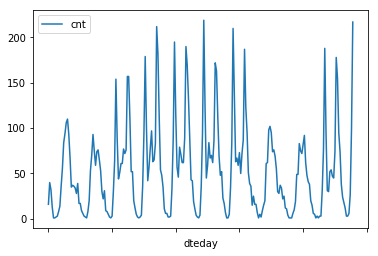

In [16]:
rides[:24*10].plot(x='dteday',y='cnt')

# 虚拟变量

In [30]:
dumpy_fields=['season','weathersit','mnth','hr','weekday']
for each in dumpy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides=pd.concat([rides,dummies],axis=1)
fields_to_drop=['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data=rides.drop(fields_to_drop,axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


#  缩放目标变量
为了使神经网络训练更加简单，我们将标准化每一个连续型变量，使每一个变量减去平均值，然后处于标准差

In [32]:
quant_features=['casual','registered','cnt','temp','hum','windspeed']

scaled_features={}
for each in quant_features:
    mean,std=data[each].mean(),data[each].std()
    scaled_features[each]=[mean,std]
    data.loc[:,each]=(data[each]-mean)/std
data.head()

G:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


# 训练集，测试集，验证集

In [19]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [20]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [21]:
# 构建神经网络
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs =np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets-final_outputs

        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) # errors propagated to the hidden layer
        hidden_grad = hidden_grad = hidden_outputs * (1.0 - hidden_outputs)# hidden layer gradients
        
        # TODO: Update the weights
        self.weights_hidden_to_output += self.lr*np.dot(output_errors,hidden_outputs.T)# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T) # update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        hidden_inputs =np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer
        
        return final_outputs

In [22]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

# 训练神网络

In [24]:
import sys

### Set the hyperparameters here ###
epochs = 500
learning_rate = 0.2
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs-1))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

G:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
G:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 100.% ... Training loss: 0.073 ... Validation loss: 0.194

(-0.025988387390207604, 0.5)

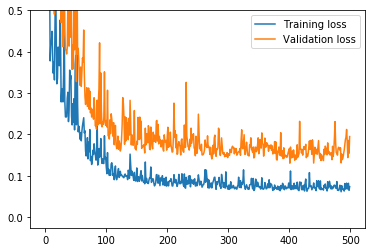

In [25]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

# 检查预测值

G:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


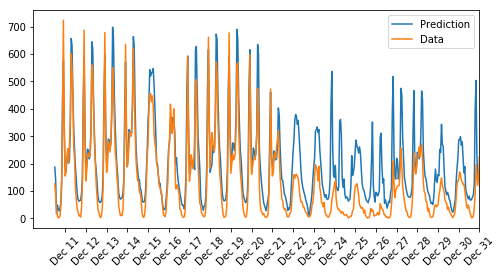

In [26]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)